In [1]:
%load_ext autoreload 

In [2]:
autoreload 2

In [3]:
%matplotlib inline

In [4]:
import numpy as np
import sympy as sym
import seaborn as sn

import pycollocation

<h1> The Solow model </h1>

$$ \dot{k}(t) = s f(k(t)) - (g + n + \delta) k(t),\ k(0) = k_0 $$

In [6]:
class SolowModel(pycollocation.TwoPointBVPLike):
    """Class representing a Solow growth model."""
    
    def __init__(self, intensive_output):
        self._bcs_upper = None
        self._bcs_upper_jac = None
        self._number_bcs_lower = 1
        self._number_odes = 1
        self._intensive_output = intensive_output
    
    @property
    def intensive_output(self):
        return self._intensive_output
    
    @staticmethod
    def _bcs_lower(t, k, k0, **params):
        return [k - k0]
    
    def _k_dot(self, t, k, delta, g, n, s, **params):
        return s * self.intensive_output(k, **params) - (g + n + delta) * k
    
    def _rhs(self, t, k, delta, g, n, s, **params):
        return [self._k_dot(t, k, delta, g, n, s, **params)]


In [7]:
def ces_output(k, alpha, sigma, **params):
    rho = (sigma - 1) / sigma
    if rho == 0:
        y = k**alpha
    else:
        y = (alpha * k**rho + (1 - alpha))**(1 / rho)
    return y

In [8]:
solow_model = SolowModel(ces_output)

In [9]:
solver = pycollocation.PolynomialSolver()

In [10]:
solow_params = {'g': 0.02, 's': 0.1, 'n': 0.02, 'alpha': 0.15, 'sigma': 2.0,
                'delta': 0.04, 'k0': 1.0}

def steady_state_capital(g, n, s, alpha, delta, sigma, **params):
    """Steady state value for capital stock (per unit effective labor)."""
    rho = (sigma - 1) / sigma
    if rho == 0:
        kss = (s / (g + n + delta))**(1 / (1 - alpha))
    else:
        kss = ((1 - alpha) / (((g + n + delta) / s)**rho - alpha))**(1 / rho)
    return kss

domain = [0, 100]
kstar = steady_state_capital(**solow_params)
ts = np.linspace(domain[0], domain[1], 1000)
ks = kstar - (kstar - solow_params['k0']) * np.exp(-ts)

initial_poly = np.polynomial.Chebyshev.fit(ts, ks, 15, domain)
initial_coefs = initial_poly.coef


In [11]:
nodes = solver.collocation_nodes(15, domain, "Chebyshev")

In [12]:
result = solver.solve(initial_coefs, domain, nodes, solow_params, solow_model,
                      kind="Chebyshev")

In [16]:
k_hat, = solver.solution_functions_factory(domain, solow_model, result, kind="Chebyshev")

In [17]:
import matplotlib.pyplot as plt

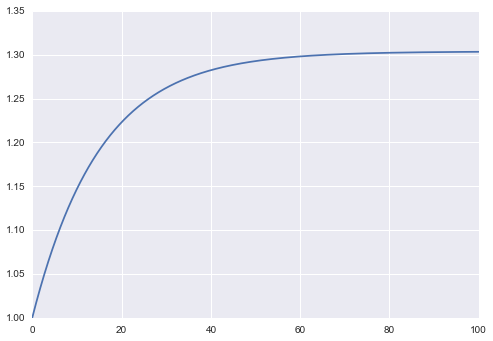

In [18]:
ts = np.linspace(0, 100, 1000)
plt.plot(ts, k_hat(ts))